In [ ]:
!pip install aerosandbox

import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, ReLU, Conv2DTranspose, Conv2D, Reshape, Dropout, Flatten
import random

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

from aerosandbox import Airfoil, KulfanAirfoil

import pandas as pd

import plotly.graph_objects as go

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 69.8 MB/s eta 0:00:00


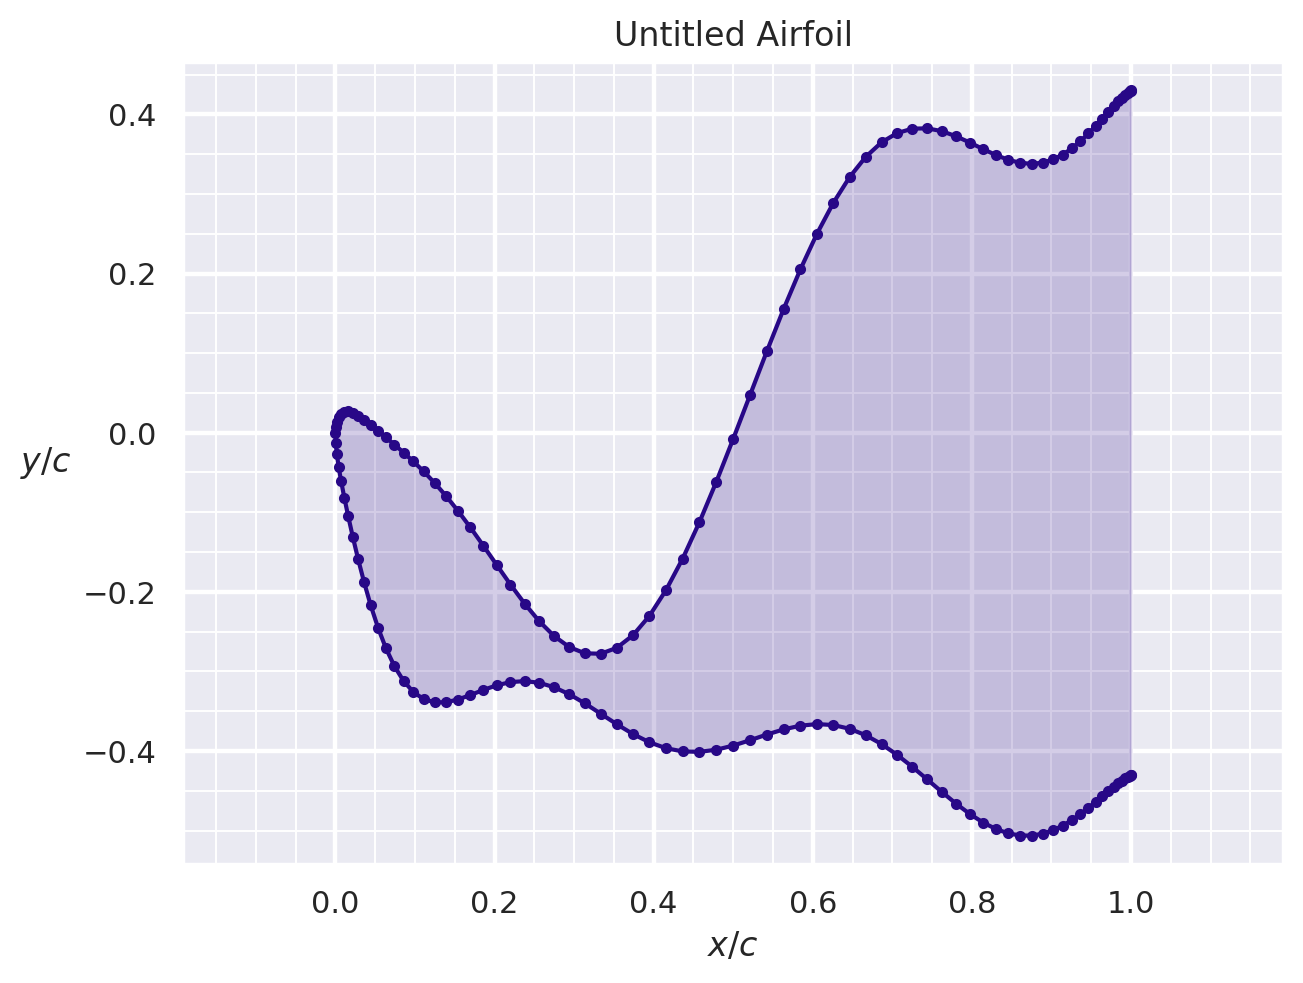

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np


class CSTLayer(Layer):
    def __init__(self, **kwargs):
        super(CSTLayer, self).__init__(**kwargs)
        self.N1 = 0.5
        self.N2 = 1
        self.n_points_per_side = 75

    def call(self, inputs, parameters):
        """
        Args:
            inputs: A 3D tensor of shape (batch_size, 2, num_weights).
                   Represents the CST weights for the upper and lower surfaces.
            parameters: A 2D tensor of shape (batch_size, 2).
                       Represents batch-specific parameters:
                       - parameters[:, 0]: TE_thickness for each sample in the batch.
                       - parameters[:, 1]: leading_edge_weight for each sample in the batch.
        """

        # Inputs is a 3D tensor: (batch_size, 2, num_weights)
        # For example, shape: (batch_size, 2, 12)
        batch_size = tf.shape(inputs)[0]
        num_weights = tf.shape(inputs)[2]

        # Split into lower and upper weights
        lower_weights = inputs[:, 0, :]  # Shape: (batch_size, num_weights)
        upper_weights = inputs[:, 1, :]  # Shape: (batch_size, num_weights)

        # Extract batch-specific parameters
        leading_edge_weight = parameters[:, 0]  # Shape: (batch_size,)
        TE_thickness = parameters[:, 1]  # Shape: (batch_size,)

        # Generate cosinically spaced points
        x = (
            1 - tf.cos(tf.linspace(0.0, np.pi, self.n_points_per_side))
        ) / 2  # Shape: (n_points_per_side,)

        # Class function
        C = (x**self.N1) * ((1 - x) ** self.N2)  # Shape: (n_points_per_side,)

        def shape_function(w):
            # Shape function (Bernstein polynomials)
            N = tf.cast(tf.shape(w)[1] - 1, dtype=tf.float32)  # num_weights - 1

            # Compute binomial coefficients using TensorFlow
            k = tf.range(N + 1, dtype=tf.float32)  # Shape: (num_weights,)
            log_comb = tf.math.lgamma(N + 1) - tf.math.lgamma(k + 1) - tf.math.lgamma(N - k + 1)
            K = tf.exp(log_comb)  # Shape: (num_weights,)

            # Expand dimensions for broadcasting
            K = tf.expand_dims(K, axis=-1)  # Shape: (num_weights, 1)
            x_expanded = tf.expand_dims(x, axis=0)  # Shape: (1, n_points_per_side)
            arange = tf.expand_dims(k, axis=-1)  # Shape: (num_weights, 1)

            # Compute Bernstein polynomials
            S_matrix = (
                K * (x_expanded**arange) * ((1 - x_expanded) ** (N - arange))
            )  # Shape: (num_weights, n_points_per_side)

            # Multiply by weights and sum over the Bernstein polynomials
            w_expanded = tf.expand_dims(w, axis=-1)  # Shape: (batch_size, num_weights, 1)
            S_x = tf.reduce_sum(w_expanded * S_matrix, axis=1)  # Shape: (batch_size, n_points_per_side)

            # Calculate the output y
            y = C * S_x  # Shape: (batch_size, n_points_per_side)
            return y

        # Apply shape function to lower and upper weights
        y_lower = shape_function(lower_weights)  # Shape: (batch_size, n_points_per_side)
        y_upper = shape_function(upper_weights)  # Shape: (batch_size, n_points_per_side)

        # Trailing edge thickness (TE thickness)
        # Reshape TE_thickness for broadcasting: (batch_size, 1)
        TE_thickness = tf.expand_dims(TE_thickness, axis=-1)  # Shape: (batch_size, 1)
        y_lower -= x * TE_thickness / 2  # Shape: (batch_size, n_points_per_side)
        y_upper += x * TE_thickness / 2  # Shape: (batch_size, n_points_per_side)

        # Leading edge modification (LEM)
        # Reshape leading_edge_weight for broadcasting: (batch_size, 1)
        leading_edge_weight = tf.expand_dims(leading_edge_weight, axis=-1)  # Shape: (batch_size, 1)
        y_lower += (
            leading_edge_weight
            * x
            * (1 - x) ** (tf.cast(num_weights, dtype=tf.float32) + 0.5)
        )
        y_upper += (
            leading_edge_weight
            * x
            * (1 - x) ** (tf.cast(num_weights, dtype=tf.float32) + 0.5)
        )

        # Create airfoil coordinates
        x = tf.tile(tf.expand_dims(x, axis=0), [batch_size, 1])  # Shape: (batch_size, n_points_per_side)
        x = tf.concat([x[:, ::-1], x[:, 1:]], axis=1)  # Shape: (batch_size, 2 * n_points_per_side - 1)
        y = tf.concat([y_upper[:, ::-1], y_lower[:, 1:]], axis=1)  # Shape: (batch_size, 2 * n_points_per_side - 1)

        # Stack x and y coordinates
        coordinates = tf.stack([x, y], axis=-1)  # Shape: (batch_size, 2 * n_points_per_side - 1, 2)
        return coordinates

# Create an instance of the CSTLayer
cst_layer = CSTLayer()

# Create dummy input data
batch_size = 3
num_weights = 12  # Number of CST weights for each surface (upper and lower)
dummy_input = tf.random.normal([batch_size, 2, num_weights])  # Shape: (batch_size, 2, num_weights)
dummy_parameters = tf.random.normal([batch_size, 2])

# Pass the input through the CSTLayer
coordinates = cst_layer(dummy_input, dummy_parameters)  # Shape: (batch_size, 2 * n_points_per_side - 1, 2)

test = Airfoil(coordinates=coordinates[0])
test.draw()

Output shape:  (3, 2, 12)
Coordinates shape:  (3, 149, 2)
tf.Tensor(
[[0.         0.5257354 ]
 [0.         0.91401714]
 [0.         0.        ]], shape=(3, 2), dtype=float32)


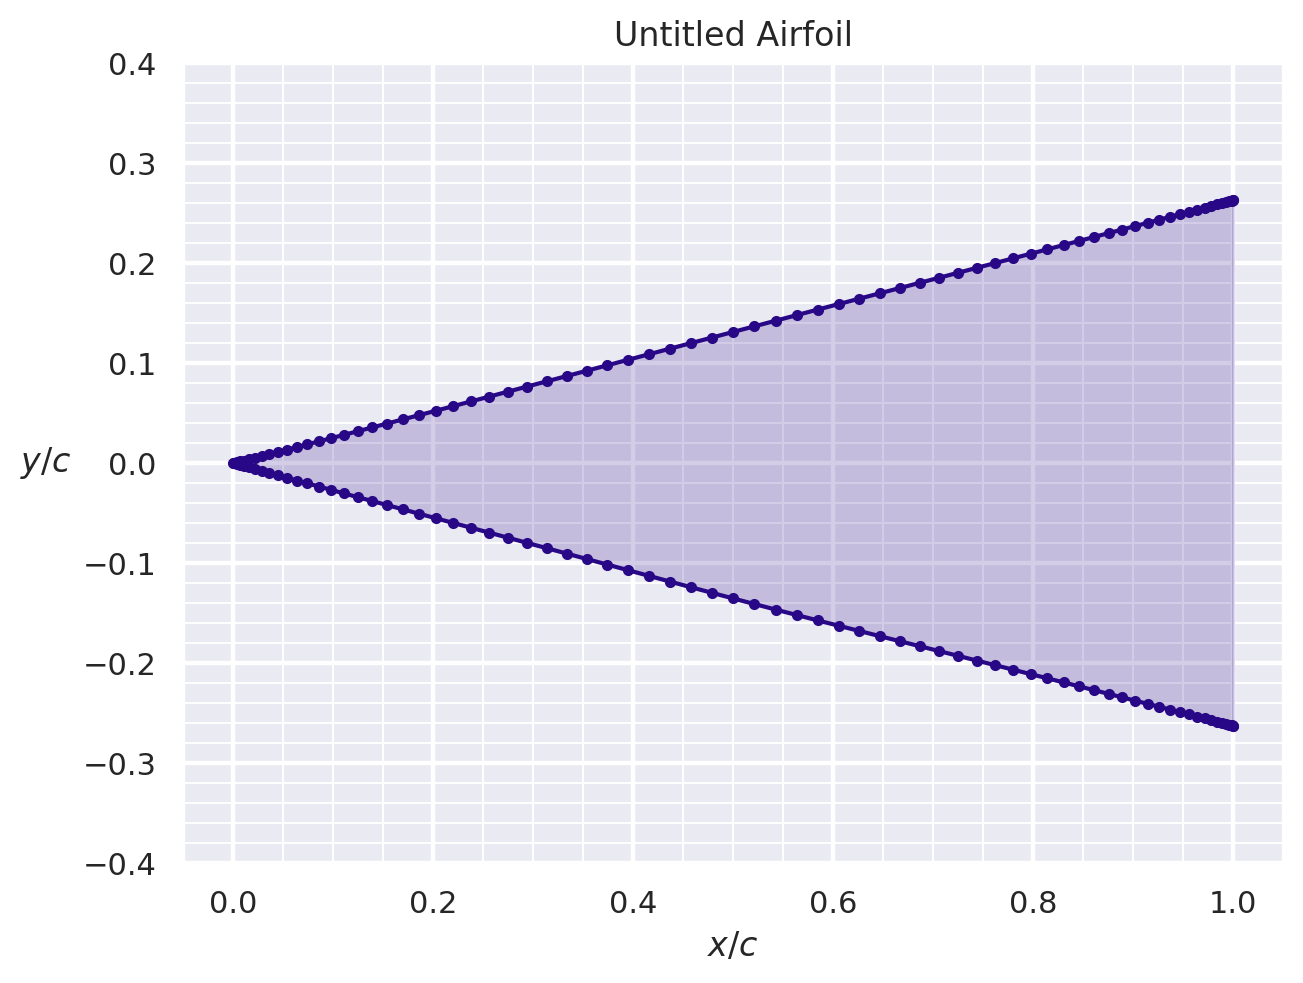

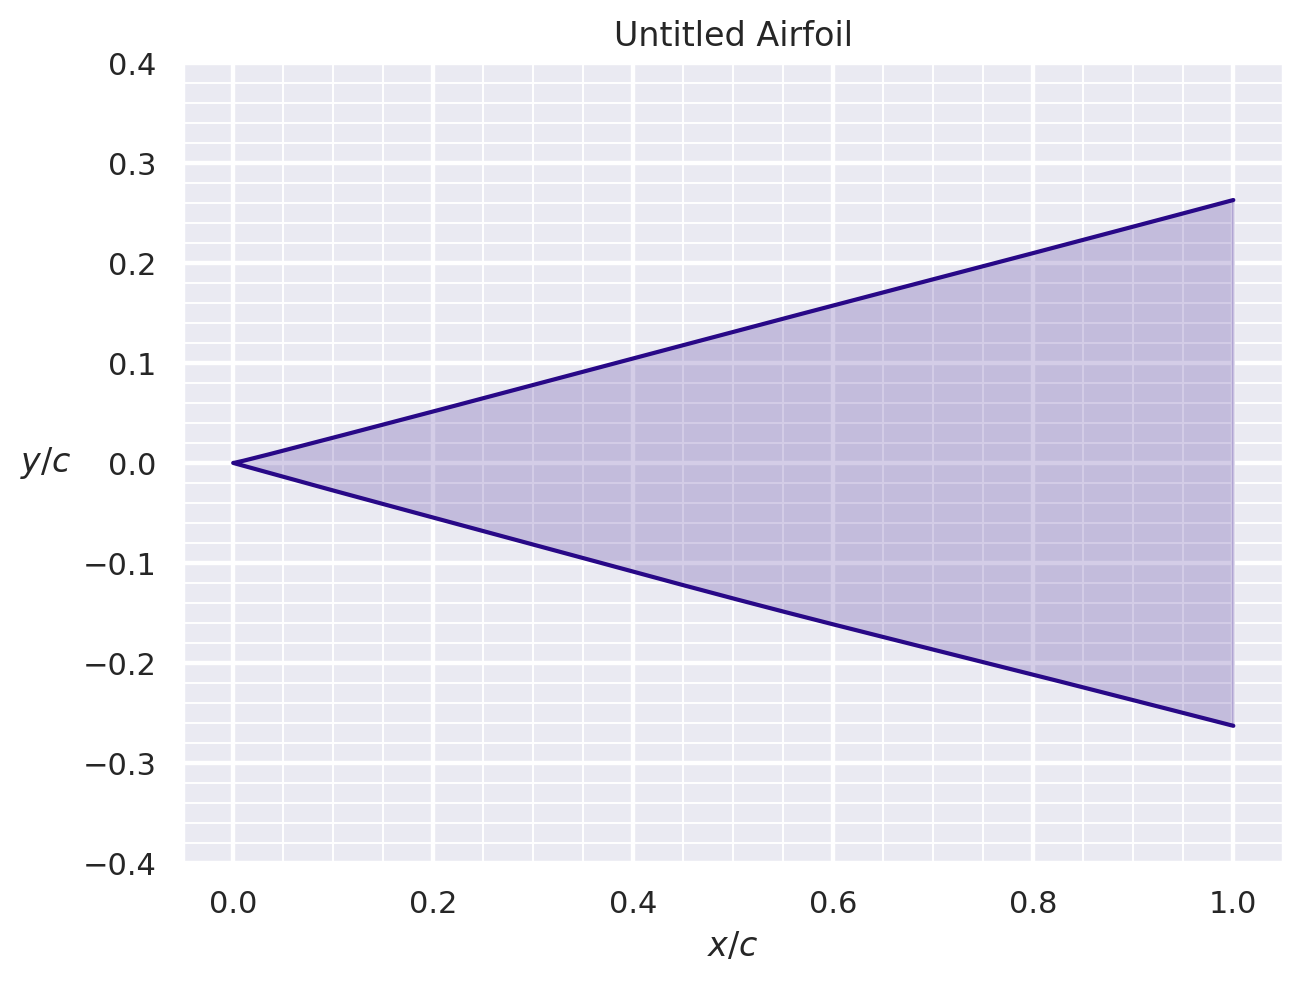

In [ ]:
class CSTGenerator(tf.keras.Model):
    '''
    * Refs:
        - Lin, Jinxing & Zhang, Chenliang & Xie, Xiaoye & Shi, Xingyu & Xu, Xiaoyu & Duan, Yanhui. (2022). CST-GANs: A Generative Adversarial Network Based on CST Parameterization for the Generation of Smooth Airfoils. 600-605. 10.1109/ICUS55513.2022.9987080.
    '''
    def __init__(self, npv: int = 12, latent_dim: int = 128, kernel_size: tuple = (2,4), depth: int = 256, use_modifications = True):
        super().__init__()

        # --- Parameters ---

        '''
        * npv: Number of parameterized variables
        * latent_dim: Dimension of input vector (latent vector)
        * depth: Number of channels after first dense layer
        '''

        self.npv = npv
        self.latent_dim = latent_dim
        self.kernel_size = kernel_size
        self.depth = depth
        self.use_modifications = use_modifications

        # --- Layers ---

        # Fully connected layers
        # CST Weights
        self.dense1 = Dense(self.depth * 2 * self.npv)
        self.batch1 = BatchNormalization(momentum=0.9)
        self.leaky_relu1 = LeakyReLU(0.2)

        self.reshape = Reshape((2, self.npv, self.depth))

        # LEM and TET
        self.dense2 = Dense(self.depth, input_shape=(self.latent_dim,))
        self.batch7 = BatchNormalization(momentum=0.9)
        self.leaky_relu7 = LeakyReLU(0.2)

        self.dense3 = Dense(int(self.depth / 4))
        self.batch8 = BatchNormalization(momentum=0.9)
        self.leaky_relu8 = LeakyReLU(0.2)

        self.dense4 = Dense(2)
        self.relu1 = ReLU()

        # Transposed convolutions
        self.deconv1 = Conv2DTranspose(int(self.depth / 2), self.kernel_size, strides=(1,2), padding='same')
        self.batch2 = BatchNormalization(momentum=0.9)
        self.leaky_relu2 = LeakyReLU(0.2)

        self.deconv2 = Conv2DTranspose(int(self.depth / 4), self.kernel_size, strides=(1,2), padding='same')
        self.batch3 = BatchNormalization(momentum=0.9)
        self.leaky_relu3 = LeakyReLU(0.2)

        self.deconv3 = Conv2DTranspose(int(self.depth / 8), self.kernel_size, strides=(1,2), padding='same')
        self.batch4 = BatchNormalization(momentum=0.9)
        self.leaky_relu4 = LeakyReLU(0.2)

        # Convolutional layers
        self.conv1 = Conv2D(int(self.depth / 16), self.kernel_size, strides=(1,2), padding="same")
        self.batch5 = BatchNormalization(momentum=0.9)
        self.leaky_relu5 = LeakyReLU(0.2)

        self.conv2 = Conv2D(int(self.depth / 32), self.kernel_size, strides=(1,2), padding="same")
        self.batch6 = BatchNormalization(momentum=0.9)
        self.leaky_relu6 = LeakyReLU(0.2)

        self.conv3 = Conv2D(1, self.kernel_size, strides=(1,2), padding="same", activation="tanh")

        # Output layers
        self.final_reshape = Reshape((2, self.npv))

        # Class-Shape Transformation
        self.cst_transform = CSTLayer()

    def call(self, inputs):
        x = self.dense1(inputs) # Input shape: (batch_size, latent_dim)
        x = self.batch1(x)
        x = self.leaky_relu1(x)

        x2 = self.dense2(inputs)
        x2 = self.batch7(x2)
        x2 = self.leaky_relu7(x2)

        x2 = self.dense3(x2)
        x2 = self.batch8(x2)
        x2 = self.leaky_relu8(x2)

        x2 = self.dense4(x2)
        parameters = self.relu1(x2)

        x = self.reshape(x)

        x = self.deconv1(x)
        x = self.batch2(x)
        x = self.leaky_relu2(x)

        x = self.deconv2(x)
        x = self.batch3(x)
        x = self.leaky_relu3(x)

        x = self.deconv3(x)
        x = self.batch4(x)
        x = self.leaky_relu4(x)

        x = self.conv1(x)
        x = self.batch5(x)
        x = self.leaky_relu5(x)

        x = self.conv2(x)
        x = self.batch6(x)
        x = self.leaky_relu6(x)

        x = self.conv3(x)
        weights = self.final_reshape(x)

        if not self.use_modifications:
          parameters = tf.zeros_like(parameters)

        coordinates = self.cst_transform(weights, parameters)

        return coordinates, weights, parameters

cst_generator = CSTGenerator()
latent_vector = tf.random.normal([3, 128])
coords, weights, parameters = cst_generator(latent_vector)
print("Output shape: ", weights.shape)
print("Coordinates shape: ", coords.shape)
print(parameters)
# test = KulfanAirfoil(lower_weights=weights[0][0], upper_weights=weights[0][1], leading_edge_weight=parameters[0][0], TE_thickness=parameters[0][1])
test = Airfoil(coordinates=coords[0])
test.draw()
test2 = KulfanAirfoil(lower_weights=weights[0][0], upper_weights=weights[0][1], leading_edge_weight=parameters[0][0], TE_thickness=parameters[0][1])
test2.draw()

In [ ]:
class CSTDiscriminator(tf.keras.Model):
    '''
    * Refs:
        - Lin, Jinxing & Zhang, Chenliang & Xie, Xiaoye & Shi, Xingyu & Xu, Xiaoyu & Duan, Yanhui. (2022). CST-GANs: A Generative Adversarial Network Based on CST Parameterization for the Generation of Smooth Airfoils. 600-605. 10.1109/ICUS55513.2022.9987080.
    '''
    def __init__(self, kernel_size: tuple = (2,3), dropout: float = 0.4, depth: int = 8, dense_units: int = 256, n_points: int = 149):
        super().__init__()

        # --- Parameters ---

        self.kernel_size = kernel_size
        self.dropout = dropout
        self.depth = depth
        self.dense_units = dense_units
        self.n_points = n_points

        # --- Layers ---

        # Convolutional layers
        self.conv1 = Conv2D(self.depth * 2, self.kernel_size, strides=(1,1), padding="same")
        self.batch1 = BatchNormalization(momentum=0.9)
        self.leaky_relu1 = LeakyReLU(0.2)
        self.dropout1 = Dropout(dropout)

        self.conv2 = Conv2D(self.depth * 4, self.kernel_size, strides=(1,2), padding="same")
        self.batch2 = BatchNormalization(momentum=0.9)
        self.leaky_relu2 = LeakyReLU(0.2)
        self.dropout2 = Dropout(dropout)

        self.conv3 = Conv2D(self.depth * 8, self.kernel_size, strides=(1,1), padding="same")
        self.batch3 = BatchNormalization(momentum=0.9)
        self.leaky_relu3 = LeakyReLU(0.2)
        self.dropout3 = Dropout(dropout)

        self.conv4 = Conv2D(self.depth * 16, self.kernel_size, strides=(1,2), padding="same")
        self.batch4 = BatchNormalization(momentum=0.9)
        self.leaky_relu4 = LeakyReLU(0.2)
        self.dropout4 = Dropout(dropout)

        self.conv5 = Conv2D(self.depth * 32, self.kernel_size, strides=(1,2), padding="same")
        self.batch5 = BatchNormalization(momentum=0.9)
        self.leaky_relu5 = LeakyReLU(0.2)
        self.dropout5 = Dropout(dropout)

        self.conv6 = Conv2D(self.depth * 64, self.kernel_size, strides=(1,2), padding="same")
        self.batch6 = BatchNormalization(momentum=0.9)
        self.leaky_relu6 = LeakyReLU(0.2)
        self.dropout6 = Dropout(dropout)

        # Fully-connected layers
        self.flatten1 = Flatten()
        self.dense1 = Dense(self.dense_units)
        self.batch7 = BatchNormalization(momentum=0.9)
        self.leaky_relu7 = LeakyReLU(0.2)

        self.dense2 = Dense(1)

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 2, self.n_points, 1])

        x = self.conv1(x)
        x = self.batch1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = self.leaky_relu3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = self.leaky_relu4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = self.leaky_relu5(x)
        x = self.dropout5(x)

        x = self.conv6(x)
        x = self.batch6(x)
        x = self.leaky_relu6(x)
        x = self.dropout6(x)

        x = self.flatten1(x)
        x = self.dense1(x)
        x = self.batch7(x)
        x = self.leaky_relu7(x)

        prediction = self.dense2(x)

        return prediction

cst_discriminator = CSTDiscriminator(n_points=12)
latent_vector = tf.random.normal([1, 2, 12, 1])
output = cst_discriminator(latent_vector)
# print("Output shape: ", coords.shape)
float(output)

0.0014304582728073

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Smoothed labels to prevent descriminator from becoming too confident
smooth_real = 0.9  # Label for real data
smooth_fake = 0.1  # Label for fake data

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * smooth_real, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) * smooth_fake, fake_output)
    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    return total_loss, tf.reduce_mean(real_loss), tf.reduce_mean(fake_loss)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
airfoil_dataset = pd.read_json("/content/drive/MyDrive/TCC/Data/kulfan_dataset_75.json")
display(airfoil_dataset)

airfoil_name                                        coordinates  \
0            2032c  [[1.0, 0.0016], [0.9995417967, 0.0016995265], ...   
1         AV-1.7-8  [[0.9999998992, 8.999540000000001e-05], [0.999...   
2     BE5030FVNC2t  [[0.9999989486, 0.0019689325000000002], [0.999...   
3     BE5045FVNC2t  [[0.999999238, 0.001931519], [0.9995510637, 0....   
4     BE5655FVNC2t  [[0.9999990278, 0.0021509264], [0.9995559253, ...   
...            ...                                                ...   
2165         ys900  [[1.0, 0.0], [0.9995461495000001, 1.53112e-05]...   
2166         ys915  [[1.0, -2.082292484e-22], [0.9995457502, 4.159...   
2167         ys920  [[1.0, -7.676703493e-20], [0.9995469423000001,...   
2168         ys930  [[1.0, 2.31071436e-21], [0.9995470971, 7.2366e...   
2169       zv15_35  [[1.0, 6.573215687e-19], [0.9995365084000001, ...   

                                      kulfan_parameters     shape  points  
0     {'lower_weights': [-0.10683679110000001, -0.14...  [149, 2]     149  
1     {'lower_weights': [-0.1152837456, -0.227979137...  [149, 2]     149  
2     {'lower_weights': [-0.0610602988, 0.0638932556...  [149, 2]     149  
3     {'lower_weights': [-0.0359906949, 0.2252238068...  [149, 2]     149  
4     {'lower_weights': [-0.0347854667, 0.2633330728...  [149, 2]     149  
...                                                 ...       ...     ...  
2165  {'lower_weights': [-0.047151649100000005, -0.1...  [149, 2]     149  
2166  {'lower_weights': [-0.0760449584, -0.189496793...  [149, 2]     149  
2167  {'lower_weights': [-0.1055076258, -0.293632588...  [149, 2]     149  
2168  {'lower_weights': [-0.0741614235, -0.082281227...  [149, 2]     149  
2169  {'lower_weights': [-0.4145909736, -0.962190769...  [149, 2]     149  

[2170 rows x 5 columns]

In [ ]:
upper = [param["upper_weights"] for param in airfoil_dataset["kulfan_parameters"].values]
lower = [param["lower_weights"] for param in airfoil_dataset["kulfan_parameters"].values]
airfoil_dataset["upper"] = upper
airfoil_dataset["lower"] = lower
weights = np.stack((upper, lower)).reshape((-1, 12, 2))
print(weights.shape)

(2170, 12, 2)


In [ ]:
batch_size = 32

real_data = weights # Shape: (n_rows, 12, 2)
real_data = tf.convert_to_tensor(real_data, dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices(real_data)
dataset = dataset.shuffle(buffer_size=1000, seed=seed).batch(batch_size)

In [ ]:
import matplotlib.pyplot as plt

# Generate and plot airfoil shapes
def generate_and_plot_airfoils(generator, num_samples=5):
    noise = tf.random.normal([num_samples, 128])
    generated_coords, _, _ = generator(noise, training=False)

    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        x = generated_coords[i, :, 0].numpy()
        y = generated_coords[i, :, 1].numpy()
        plt.plot(x, y, label=f"Airfoil {i + 1}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Generated Airfoils')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# generate_and_plot_airfoils(generator)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


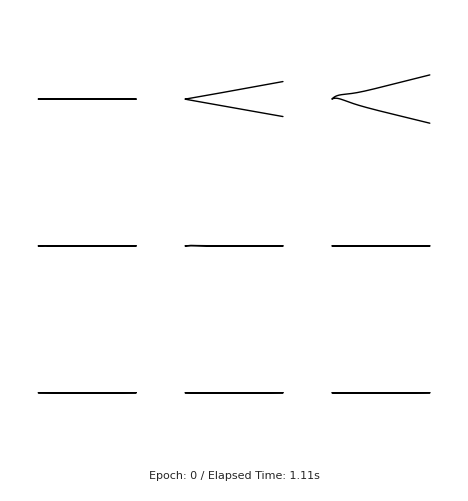

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_plot_airfoils(generator, epoch: int = None, num_airfoils=9, scale=0.8, scatter=False, annotate=False, dot_size=20, figsize=(5, 5), linewidth=1.0, time=None):

  def plot_samples(airfoils, scale=0.8, scatter=False, annotate=False, dot_size=20, figsize=(5,5), linewidth=1.0, **kwargs):
      '''
      Plot airfoil coordinates inline.

      Parameters:
      -----------
      airfoils : list of Airfoil objects
          List of Airfoil objects containing the coordinates to be plotted.
      scale : float, optional
          Scaling factor for the plot.
      scatter : bool, optional
          Whether to plot the shapes as a scatter plot.
      annotate : bool, optional
          Whether to annotate the points with their indices.
      dot_size : int, optional
          Size of the dots in the scatter plot.
      figsize : tuple, optional
          Size of the figure (width, height) in inches. Default is (5, 5).
      linewidth : float, optional
          Thickness of the lines when plotting shapes. Default is 1.0.
      **kwargs : dict
          Additional keyword arguments for plotting.
      '''

      # Create a 2D plot with a customizable figure size
      fig, ax = plt.subplots(figsize=figsize)

      # Generate a grid for positioning airfoils
      N = len(airfoils)
      points_per_axis = int(np.sqrt(N))
      bounds = (0., 1.)
      Z = gen_grid(2, points_per_axis, bounds[0], bounds[1])  # Generate a grid

      scale /= points_per_axis

      for (i, z) in enumerate(Z):
          # Extract coordinates from the Airfoil object
          coordinates = airfoils[i].coordinates
          plot_shape(coordinates, z[0], z[1], ax, scale, scatter, dot_size, linewidth, **kwargs)
          if annotate:
              label = '{0}'.format(i+1)
              ax.annotate(label, xy=(z[0], z[1]), size=10)

      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
      plt.axis('equal')
      plt.tight_layout()

      # Add a text box at the bottom to display losses
      if time is not None and epoch is not None:
          loss_text = f"Epoch: {epoch} / Elapsed Time: {time:.2f}s"
          plt.figtext(0.5, 0.01, loss_text, ha="center", fontsize=4)

      plt.savefig('./images/image_at_epoch_{:04d}.png'.format(epoch))
      plt.show()  # Display the plot inline

  def plot_shape(coordinates, x, y, ax, scale, scatter, dot_size, linewidth, **kwargs):
      '''
      Helper function to plot a single shape.

      Parameters:
      -----------
      coordinates : numpy.ndarray
          The coordinates of the shape to be plotted.
      x : float
          The x-coordinate for the shape's position.
      y : float
          The y-coordinate for the shape's position.
      ax : matplotlib.axes.Axes
          The axis to plot on.
      scale : float
          Scaling factor for the plot.
      scatter : bool
          Whether to plot the shapes as a scatter plot.
      dot_size : int
          Size of the dots in the scatter plot.
      linewidth : float
          Thickness of the lines when plotting shapes.
      **kwargs : dict
          Additional keyword arguments for plotting.
      '''
      # Adjust coordinates based on the position (x, y) and scale
      adjusted_coords = coordinates * scale + np.array([x, y])

      if scatter:
          ax.scatter(adjusted_coords[:, 0], adjusted_coords[:, 1], s=dot_size, color='black', **kwargs)
      else:
          ax.plot(adjusted_coords[:, 0], adjusted_coords[:, 1], color='black', linewidth=linewidth, **kwargs)

  def gen_grid(dim, points_per_axis, lower_bound, upper_bound):
      '''
      Generate a grid of points in the specified dimension.

      Parameters:
      -----------
      dim : int
          The dimension of the grid.
      points_per_axis : int
          Number of points per axis.
      lower_bound : float
          Lower bound for the grid.
      upper_bound : float
          Upper bound for the grid.

      Returns:
      --------
      numpy.ndarray
          A grid of points.
      '''
      # Generate a grid of points
      grid = np.mgrid[[slice(lower_bound, upper_bound, points_per_axis*1j) for _ in range(dim)]]
      grid = grid.reshape(dim, -1).T
      return grid

  # Example usage:
  noise = tf.random.normal([num_airfoils, 128])
  generated_coords, _, _ = generator(noise, training=False)

  # Create a list of Airfoil objects with random coordinates
  airfoils = [Airfoil(coordinates=coords) for coords in generated_coords]

  plot_samples(airfoils, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

test_generator = CSTGenerator()

generate_and_plot_airfoils(test_generator, time=1.1122, epoch=0, num_airfoils=9, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

In [ ]:
from tqdm import tqdm
import time

@tf.function
def train_step(real_data, gen_train_multiple = 1, disc_train_multiple = 1, add_noise=False):
    batch_size = tf.shape(real_data)[0]

    # Generate random latent vectors
    noise = tf.random.normal([batch_size, 128])

    for _ in range(gen_train_multiple):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_data, weights, _ = generator(noise, training=True)

        fake_output = discriminator(weights, training=True)

        gen_loss = generator_loss(fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    for _ in range(disc_train_multiple):
      with tf.GradientTape() as disc_tape:
        # Generate fake data (again, since the generator was updated)
        fake_data, weights, _ = generator(noise, training=True)

        # Discriminator predictions on real and fake data
        if add_noise:
          # Add noise to discriminator data
          real_data_noisy = real_data + tf.random.normal(tf.shape(real_data), mean=0.0, stddev=0.1)
          fake_data_noisy = fake_data + tf.random.normal(tf.shape(fake_data), mean=0.0, stddev=0.1)
          real_output = discriminator(real_data_noisy, training=True)
          fake_output = discriminator(fake_data_noisy, training=True)
        else:
          real_output = discriminator(real_data, training=True)
          # fake_output = discriminator(fake_data, training=True)
          fake_output = discriminator(weights, training=True)

        real_output = discriminator(real_data, training=True)
        # fake_output = discriminator(fake_data, training=True)
        fake_output = discriminator(weights, training=True)

        # Discriminator loss
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_loss(real_output, fake_output)

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, disc_real_loss, disc_fake_loss, gen_loss

def train(dataset, epochs, add_noise = False):
  elapsed_time = 0

  # Training loop
  for epoch in range(epochs):
      print(f"\nEpoch {epoch + 1}/{epochs}")
      start_time = time.time()

      # Initialize epoch losses
      epoch_disc_loss = 0.0
      epoch_gen_loss = 0.0
      epoch_real_loss = 0.0
      epoch_fake_loss = 0.0
      num_batches = 0

      # Iterate over the dataset with a progress bar
      for batch in tqdm(dataset, desc="Training"):
          # Perform a training step
          disc_loss, disc_real_loss, disc_fake_loss, gen_loss = train_step(batch, gen_train_multiple=1, disc_train_multiple=1, add_noise=add_noise)

          # Accumulate losses
          epoch_disc_loss += disc_loss.numpy()
          epoch_gen_loss += gen_loss.numpy()
          epoch_real_loss += disc_real_loss.numpy()
          epoch_fake_loss += disc_fake_loss.numpy()
          num_batches += 1

      # Calculate average losses for the epoch
      avg_disc_loss = epoch_disc_loss / num_batches
      avg_gen_loss = epoch_gen_loss / num_batches
      avg_real_loss = epoch_real_loss / num_batches
      avg_fake_loss = epoch_fake_loss / num_batches

      # Print epoch results
      epoch_time = time.time() - start_time
      elapsed_time = elapsed_time + epoch_time
      print(f"\nDiscriminator Loss: {avg_disc_loss:.4f}, Generator Loss: {avg_gen_loss:.4f}, Time: {epoch_time:.2f}s")

      print("Generating and plotting airfoils...")
      # Produce images for the GIF as you go
      # display.clear_output(wait=True)
      generate_and_plot_airfoils(generator, time=elapsed_time, epoch=epoch + 1, num_airfoils=9, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

      # Save model checkpoints every 5 epochs
      if (epoch + 1) % 5 == 0:
          print("Saving model checkpoints...")
          # Save the generator
          generator.save(f"./models/generator_model_{epoch+1}.keras")

          # Save the discriminator
          discriminator.save(f"./models/discriminator_model_{epoch+1}.keras")

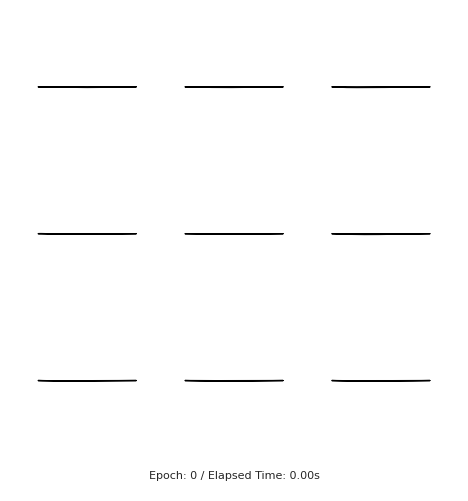


Epoch 1/10000


Training:   0%|          | 0/68 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['cst_generator_4/dense_21/kernel', 'cst_generator_4/dense_21/bias', 'cst_generator_4/batch_normalization_47/gamma', 'cst_generator_4/batch_normalization_47/beta', 'cst_generator_4/dense_22/kernel', 'cst_generator_4/dense_22/bias', 'cst_generator_4/batch_normalization_48/gamma', 'cst_generator_4/batch_normalization_48/beta', 'cst_generator_4/dense_23/kernel', 'cst_generator_4/dense_23/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Training:  65%|██████▍   | 44/68 [00:27<00:15,  1.58it/s]


KeyboardInterrupt: 

In [ ]:
generator = CSTGenerator(latent_dim = 128, depth=512, use_modifications=True)
discriminator = CSTDiscriminator(depth=1, dense_units=256, n_points = 12)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1= 0.5)

generate_and_plot_airfoils(generator, time=0, epoch=0, num_airfoils=9, scale=1, scatter=False, annotate=False, figsize=(2.5, 2.5), linewidth=0.5)

EPOCHS = 10000

train(dataset, EPOCHS, add_noise=True)

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import imageio
import glob

anim_file = 'plainGAN_149_points.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


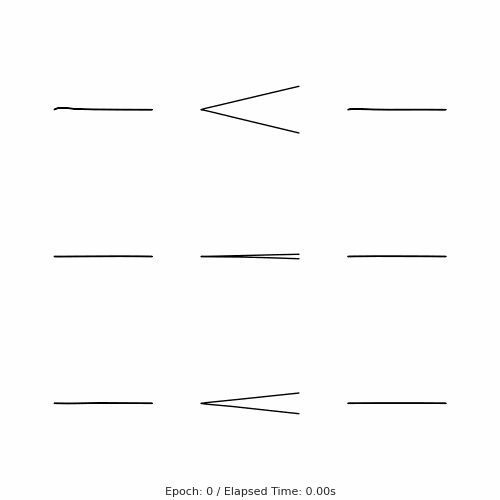

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

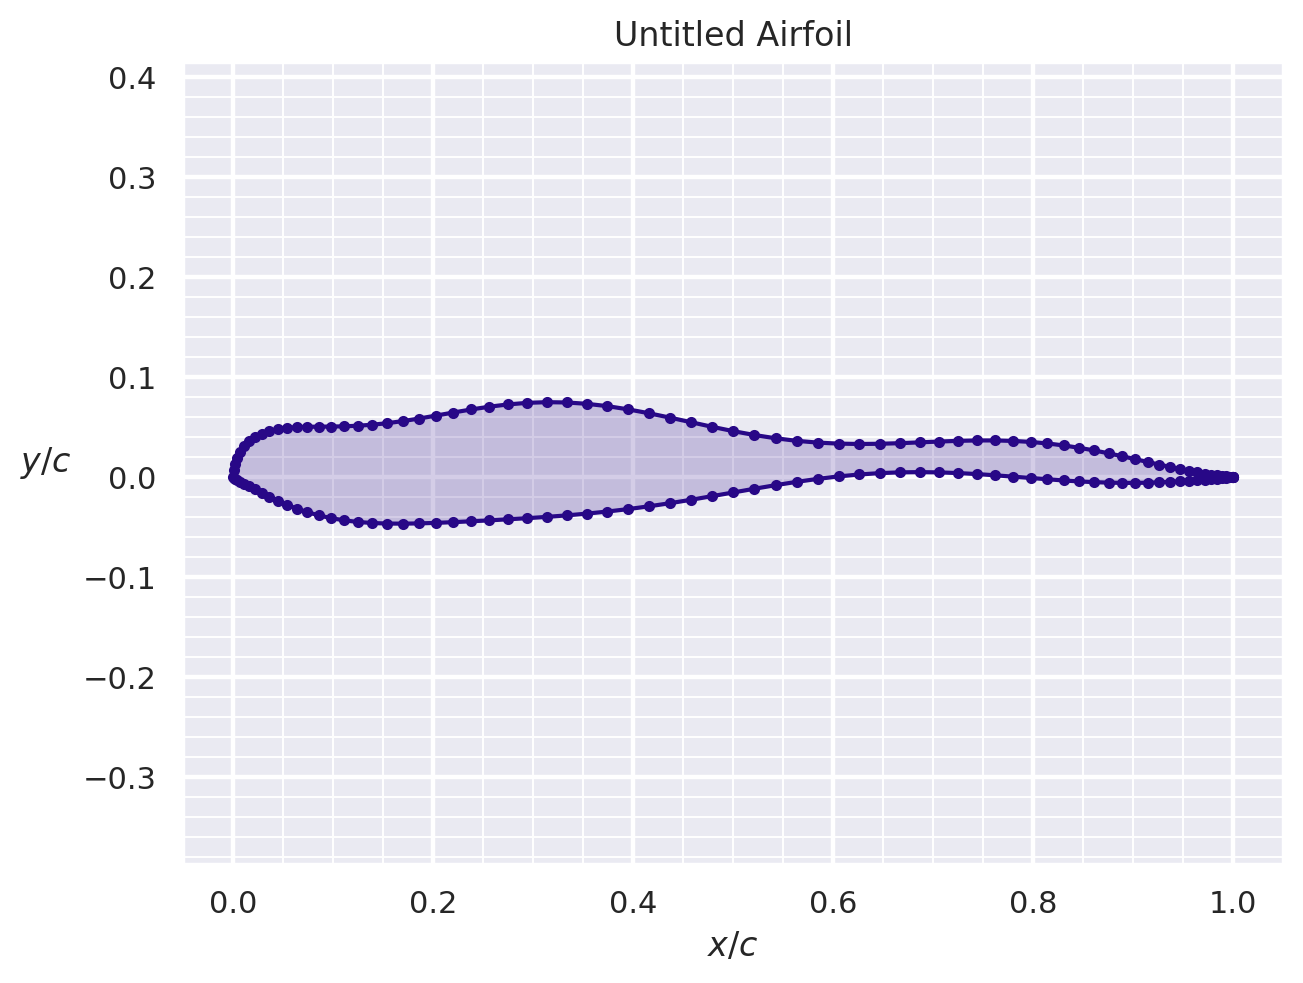

In [ ]:
noise = tf.random.normal([1, 128])
generated_coords, _, _ = generator(noise, training=False)
test = Airfoil(coordinates=generated_coords[0])
test.draw()